# Задача
В этой работе вам предлагается решить задачу бинарной классификации, а именно построить алгоритм, определяющий превысит ли средний заработок человека порог $50k. Каждый объект выборки — человек, для которого известны следующие признаки:
 - age
 - workclass
 - fnlwgt
 - education
 - education-num
 - marital-status
 - occupation
 - relationship
 - race
 - sex
 - capital-gain
 - capital-loss
 - hours-per-week
 
Более подробно про признаки можно почитать [здесь](http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names). Целевой признак записан в переменной *>50K,<=50K*.

В этой задаче для обучения будут использовать 2 алгоритма:
 - [kNN](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
 - [DecisonTree](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)

# Решение

Загрузите набор данных *data.adult.csv* с помощью `pandas` (скачать можно [здесь](https://drive.google.com/file/d/1Lo47fXx1RrJG3v9E-Gck1T45n5bJ_SJf/view?usp=sharing), или с помощью скрипта ниже). Чтобы лучше понимать, с чем вы работаете/корректно ли вы загрузили данные можно вывести несколько первых строк на экран.

#### Import

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # yeah, sure buddy

In [2]:
import pandas as pd
import numpy as np
import sklearn as skl
import imblearn as imb

from collections import Counter

Для работы будем использовать основные метрики: `balanced_accuracy` и `f1`. У нас несбалансированная выборка (о чем можно узнать по ссылке в введении, а также в анализе датасета ниже), поэтому `accuracy` не подойдет для корректной оценки классификатора. В свою очередь `f1` укажет на ошибки I и II рода.

>`precision` и `recall` используются как второстепенные метрики, т.к. "входят" в метрику `f1`.

In [3]:
from sklearn.metrics import balanced_accuracy_score, f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score, recall_score

# Просмотр результатов
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


Ключевые модели: `DecisionTreeClassifier` и `KNeighborsClassifier`.

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.base import clone

Кросс-валидацию для поиска оптимальных параметров будем искать путем `GridSearchCV`, также настроим параметры кросс-валидации через `StratifiedKFold`:

In [5]:
from sklearn.model_selection import GridSearchCV # для поиска оптимальных гиперпараметров
from sklearn.model_selection import StratifiedKFold # для лучшего контроля кросс-валидации

from sklearn.model_selection import cross_val_score

Препроцессинг, трансформация и разбиение данных:

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

>Еще были сделаны шаги для балансирования целевых лейблов методом `NeighbourhoodCleaningRule` ([подробнее](#balancing_classes)):

In [7]:
# Undersampling
from imblearn.under_sampling import NeighbourhoodCleaningRule

Визуализация:

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt
from scikitplot.metrics import plot_roc


from sklearn import tree # для демонстрации: как устроено дерево

In [9]:
RANDOM_STATE = 42

#### Технические функции

In [10]:
target_classes = ['>50K', '<=50K']
cross_validation = StratifiedKFold(n_splits=5, shuffle=False)
grid_search_scoring = ['balanced_accuracy', 'precision', 'recall', 'f1_macro']

color_sns = 'YlOrBr'

In [11]:
def plot_confusionmatrix(y_train_pred, y_train, dom):
  """Функция строит матрицу конфузии для бинарной классификации

  Arguments:
    y_train_pred: вектор предсказанных данных на датасете размером (n_features, 1);
    y_train: вектор исходных таргет-данных на датасете размером (n_features, 1);
    dom: описание
  """

  print(f'Матрица конфузии на {dom} выборке')
  cf = confusion_matrix(y_train_pred, y_train)
  sns.heatmap(cf,
              annot=True,
              yticklabels=target_classes,
              xticklabels=target_classes,
              cmap=color_sns,
              fmt='g')
  plt.tight_layout()
  plt.show()

In [12]:
def create_plot_data(clf_gridsearch, x_col="param_n_estimators"):
  """Парсит словарь GridSearchCV в данные для графика

  Arguments:
    clft_gridsearch: обученный класс GridSearchCV
    x_col: столбец значений признака для исследования

  Returns:
    tuple object: (X, y_accuracy_score, y_f1_score) одинакового размера (index=0)
  """

  clf_pd = pd.DataFrame(clf_gridsearch.cv_results_)
  clf_pd_subdata = clf_pd[[x_col, "mean_test_balanced_accuracy", "mean_test_f1_macro"]]
  clf_pd_subdata.sort_values(by=[x_col])
  clf_pd_subdata_data = clf_pd_subdata.values.tolist()

  clf_pd_subdata_data_X = []
  clf_pd_subdata_data_Y = [[], []]

  for elem in clf_pd_subdata_data:
    clf_pd_subdata_data_X.append(elem[0])
    clf_pd_subdata_data_Y[0].append(elem[1]) #accuracy
    clf_pd_subdata_data_Y[1].append(elem[2]) #f1_score

  return(clf_pd_subdata_data_X, clf_pd_subdata_data_Y)

In [13]:
def plot_GSCV_score(grid_search, plt_label_x, plt_title, metric='f1_score', x_col="param_max_depth"):
    """Создает график изменения точности модели от изменяемых параметрах в GridSearchCV по метрике f1

    Arguments:
      grid_search: обученный класс GridSearchCV
      plt_label_x: описание для оси ординат
      plt_title: титульник графика
      metric: метрика для исследования
      x_col: столбец значений признака для исследования
    
    """

    # Выбор метрики
    if metric == 'f1_score':
        metric_idx = 1
        metric_dict = 'mean_test_f1_macro'
        metric_label = "f1 score"
    elif metric == 'balanced_accuracy':
        metric_idx = 0
        metric_dict = 'mean_test_balanced_accuracy'
        metric_label = "Balanced accuracy score"
    else:
        raise TypeError("Unknown metric")

    # Обработка значений
    (X_plot, Y_plot) = create_plot_data(grid_search, x_col)

    CI = 1.96 * np.std(Y_plot[metric_idx])/np.sqrt(len(Y_plot[metric_idx]))

    ymin = min(grid_search.cv_results_[metric_dict]) -0.1
    ymax = max(grid_search.cv_results_[metric_dict]) +0.1

    # Создание графика
    fig, ax = plt.subplots()
    
    ax.plot(X_plot, Y_plot[metric_idx], label='F1 score', color='g')
    ax.fill_between(X_plot, (Y_plot[metric_idx]-CI), (Y_plot[metric_idx]+CI), color='g', alpha=.1)

    ax.set(xlabel=plt_label_x, ylabel=metric_label, title=plt_title, ylim=(ymin, ymax))
    ax.grid()
    ax.legend()

    plt.show()

#### Загрузка датасета

In [14]:
dataset_pd = pd.read_csv('data_adult.csv', delimiter=',')
dataset_pd.head(20)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
0,34,Local-gov,284843,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,594,0,60,<=50K
1,40,Private,190290,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,40,<=50K
2,36,Local-gov,177858,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,0,0,40,<=50K
3,22,Private,184756,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30,<=50K
4,47,Private,149700,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,15024,0,40,>50K
5,18,Private,446771,Some-college,10,Never-married,Adm-clerical,Own-child,White,Male,0,0,25,<=50K
6,31,Federal-gov,108464,Assoc-acdm,12,Married-civ-spouse,Tech-support,Husband,White,Male,0,0,40,<=50K
7,18,?,423460,11th,7,Never-married,?,Own-child,White,Male,0,0,36,<=50K
8,25,Private,110138,HS-grad,9,Never-married,Other-service,Not-in-family,White,Male,0,0,40,<=50K
9,53,Federal-gov,167410,Bachelors,13,Divorced,Tech-support,Not-in-family,Amer-Indian-Eskimo,Male,0,0,40,<=50K


Заменим в задаче бинарной классификации целевую переменную на 1 и 0:

In [15]:
target_to_replace = dataset_pd[">50K,<=50K"].unique()
dataset_pd[">50K,<=50K"].replace(to_replace=target_to_replace[0], value=0, inplace=True)
dataset_pd[">50K,<=50K"].replace(to_replace=target_to_replace[1], value=1, inplace=True)

In [16]:
dataset_pd.shape

(16280, 14)

In [17]:
dataset_pd.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
count,16280.000000,1.628000e+04,16280.000000,16280.000000,16280.000000,16280.000000,16280.000000
mean,38.635074,1.894594e+05,10.098219,1020.417752,86.696314,40.403686,0.247912
std,13.635301,1.066644e+05,2.567690,6862.041550,402.308715,12.341191,0.431813
min,17.000000,1.930200e+04,1.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,1.170068e+05,9.000000,0.000000,0.000000,40.000000,0.000000
50%,37.000000,1.781340e+05,10.000000,0.000000,0.000000,40.000000,0.000000
75%,48.000000,2.371630e+05,12.000000,0.000000,0.000000,45.000000,0.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000,1.000000


## Анализ и предобработка данных

Обычно после загрузки датасета всегда необходима его некоторая предобработка. В данном случае она будет заключаться в следующем: 
1. Проверьте есть ли в данных пропущенные значения (здесь они обозначены как "?"). Удалите из выборки все объекты с пропусками.
2. Выделите 60% выборки для обучения и дальнейшего анализа.
3. Обратите внимание, что не все признаки являются вещественными (числовыми). Сначала их необходимо проанализировать и по необходимости предобработать. Все шаги предобработки поясните текстом.
4. Целевую переменную (ту, которую мы хотим предсказывать) можно выделить в отдельную переменную и преобразуйте к бинарному формату (НЕ забудьте удалить ее из датасета, когда будете обучать модель).


In [18]:
dataset_pd = dataset_pd.mask(dataset_pd == '?')
dataset_pd.dropna(inplace=True)
dataset_pd.drop_duplicates(inplace=True)
dataset_pd.shape

(15335, 14)

In [19]:
data = dataset_pd.drop(['>50K,<=50K'], axis=1)
target = dataset_pd['>50K,<=50K']

Нужно применить кодировку категориальных данных. Кодировка `ordinal encoding (OE)` подходит по смыслу только для признака `education`, но в датасете уже существует `education-num`. Так что используем по умолчанию `one-hot enconding (OHE)`.

In [20]:
dataset_pd.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
0,34,Local-gov,284843,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,594,0,60,0
1,40,Private,190290,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,40,0
2,36,Local-gov,177858,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,0,0,40,0
3,22,Private,184756,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30,0
4,47,Private,149700,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,15024,0,40,1


<a id='pairplot_before'></a>
Посмотрим на распределение образцов в датасете:

c:\ProgramData\anaconda3\envs\PythonDL\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


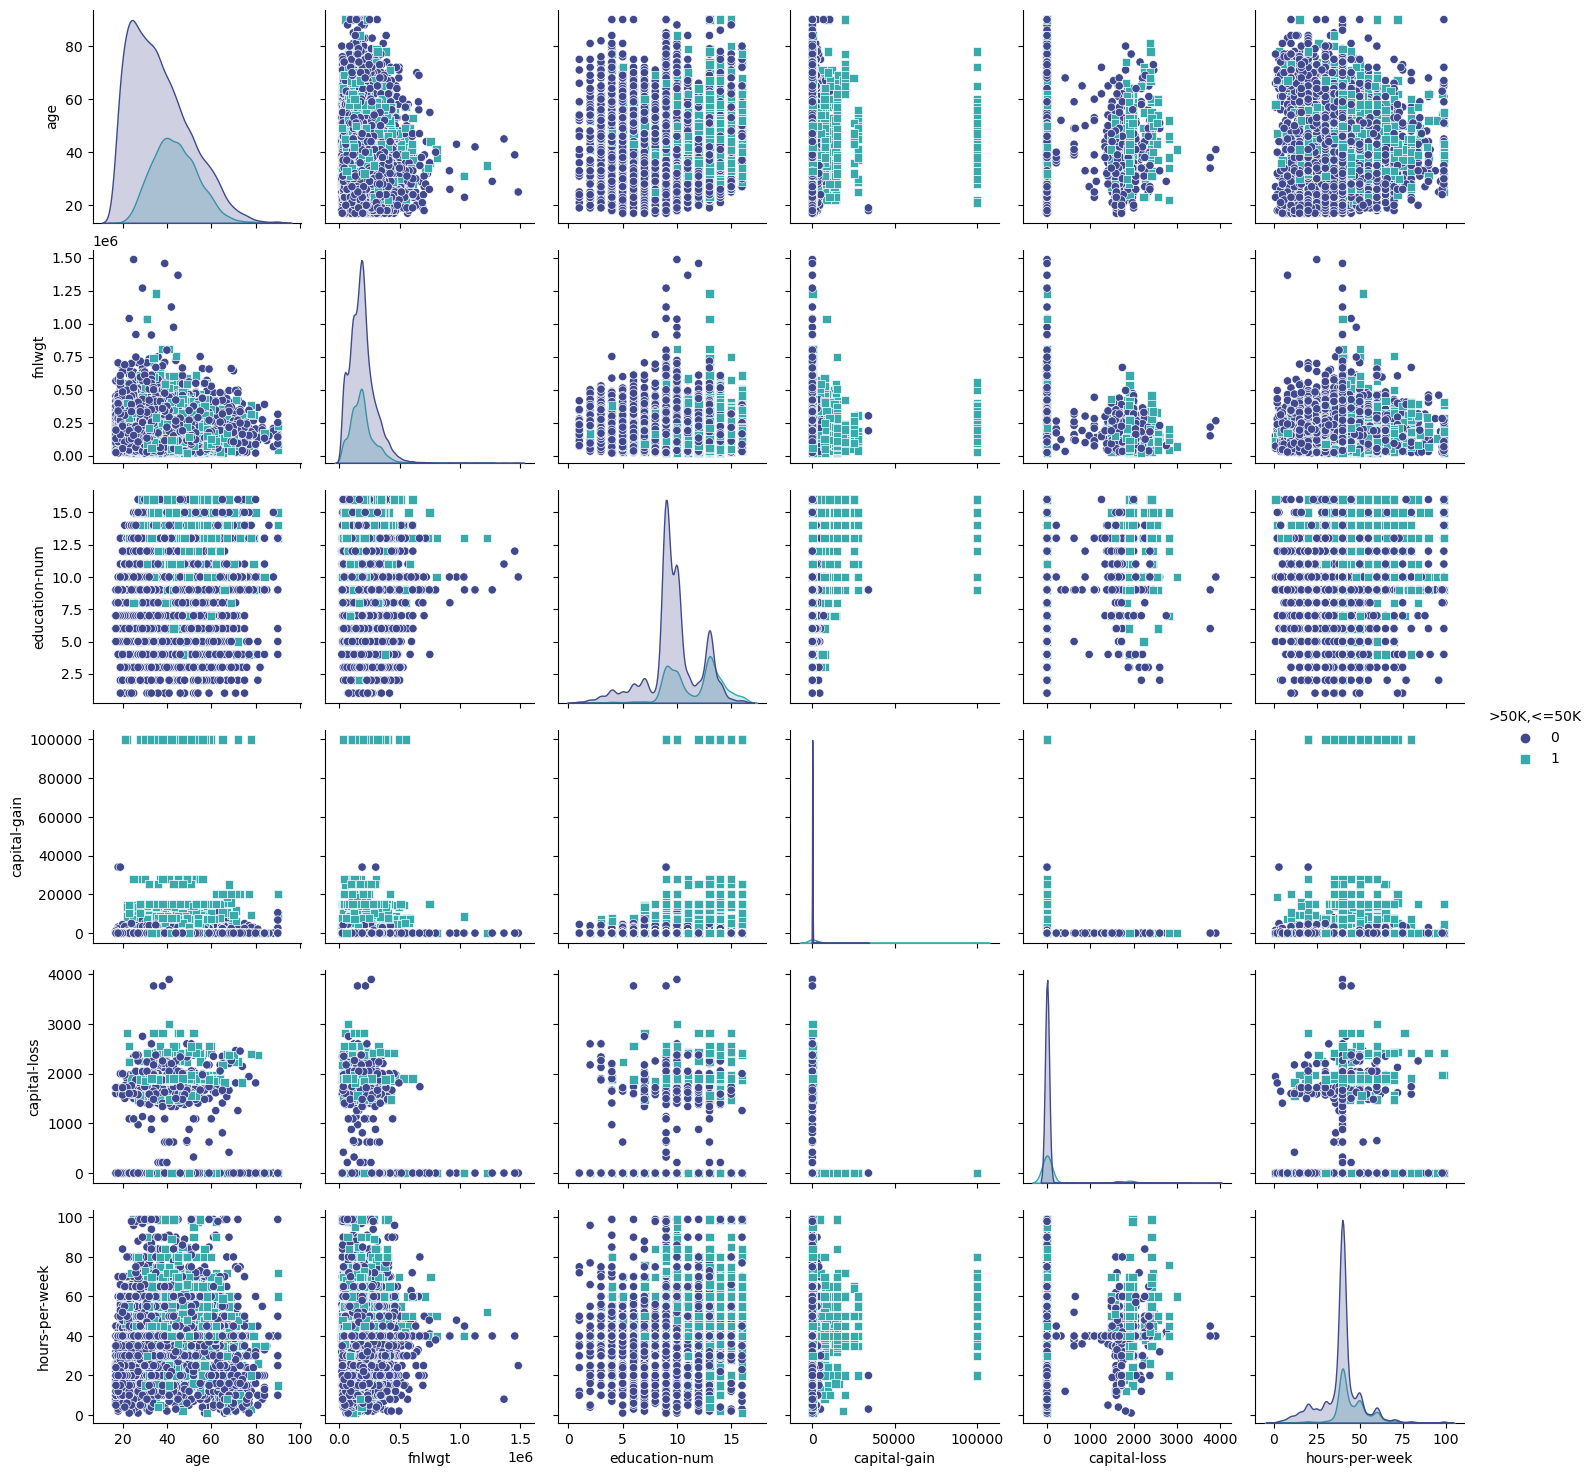

In [32]:
sns.pairplot(dataset_pd, kind='scatter', hue='>50K,<=50K', diag_kind='kde', palette="mako", markers=["o", "s"])

Видно, что минорный класс нельзя четко определить, т.к. некоторые данные не находятся в одной области пространства признаков. Поэтому необходимо сбалансировать датасеты (этот шаг трансформирования выборки будет [ниже](#balancing_classes)), чтобы мы могли правильно обучить `DecisionTree`.

Анализ распределения значений признаков:

In [279]:
# Категориальные: 
cat_cols = ["workclass",
            "education",
            "marital-status",
            "occupation",
            "relationship",
            "race",
            "sex",
            ]

# Числовые:
num_cols = ["age",
            "fnlwgt",
            "education-num",
            "capital-gain",
            "capital-loss",
            "hours-per-week"]

for feature_val in cat_cols:
    print(f"{feature_val}: \t{dataset_pd[feature_val].unique()}\n")

workclass: 	['Local-gov' 'Private' 'Federal-gov' 'Self-emp-inc' 'State-gov'
 'Self-emp-not-inc' 'Without-pay']

education: 	['HS-grad' 'Some-college' 'Bachelors' 'Assoc-acdm' '12th' 'Doctorate'
 '1st-4th' '7th-8th' 'Masters' '5th-6th' '11th' '9th' 'Assoc-voc'
 'Prof-school' '10th' 'Preschool']

marital-status: 	['Never-married' 'Divorced' 'Married-civ-spouse' 'Separated'
 'Married-spouse-absent' 'Married-AF-spouse' 'Widowed']

occupation: 	['Farming-fishing' 'Sales' 'Prof-specialty' 'Tech-support' 'Adm-clerical'
 'Other-service' 'Machine-op-inspct' 'Protective-serv' 'Transport-moving'
 'Exec-managerial' 'Craft-repair' 'Handlers-cleaners' 'Priv-house-serv'
 'Armed-Forces']

relationship: 	['Not-in-family' 'Own-child' 'Husband' 'Unmarried' 'Wife' 'Other-relative']

race: 	['Black' 'White' 'Amer-Indian-Eskimo' 'Asian-Pac-Islander' 'Other']

sex: 	['Male' 'Female']



При обучении алгоритмов стоит обращать внимание не только на их качество, но и каким образом они работают с данными. Давайте посмотрим на значения самих признаков.

Что можете сказать о разбросе данных и сбалансированности выборки? В каком диапазоне лежат исследуемые признаки?

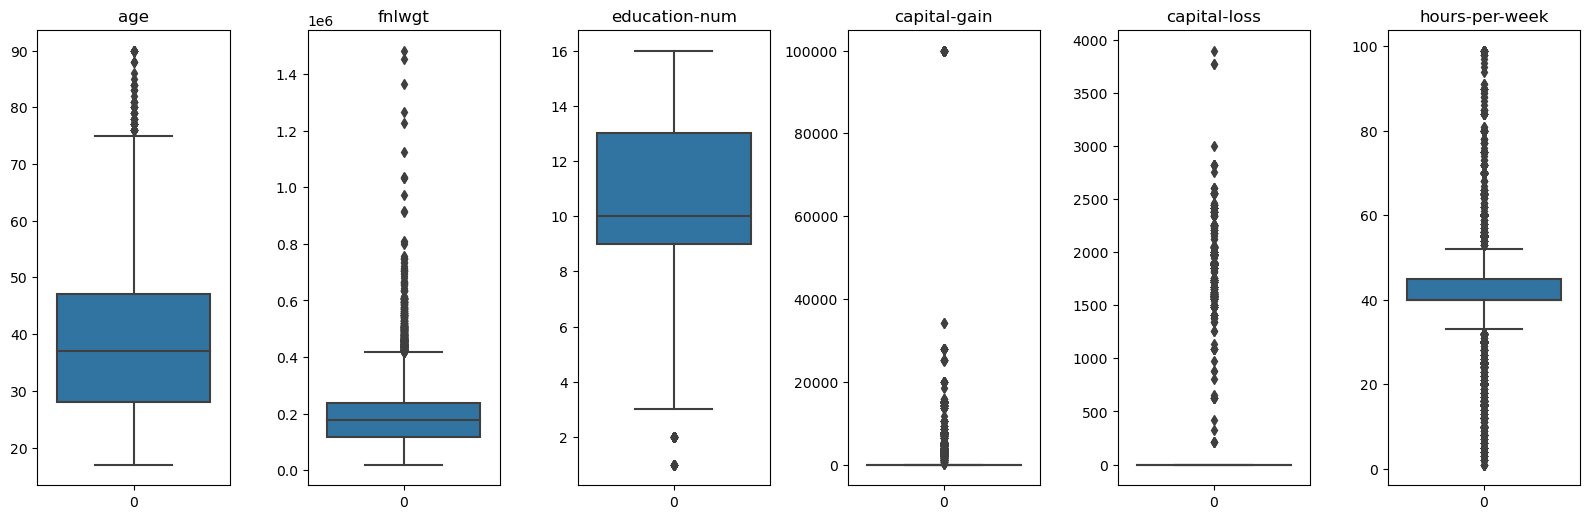

In [280]:
# Категориальные данные
plt.figure(figsize=(16,10))
for i,col in enumerate(num_cols):    
    plt.subplot(2,6,i + 1)
    ax = sns.boxplot(data=data[col])
    ax.set_title(col)

plt.tight_layout()
plt.show()

Важное замечание: `sns.boxplot` отмечает выбросы данных как черный ромб. Это выбросы по определению, совсем не значит, что от них стоит избавляться. Но по определению $IQR$ можно сделать вывод, что в выборке очень много людей с нулевым значением признаков `capital-gain` и `capital-loss`. Информация о датасете довольно поверхностная, поэтому я не могу сделать вывод что делать с этими признаками. Оставляем.

In [281]:
# Численные данные
num_all = data.shape[0]

for i, col in enumerate(cat_cols):
    print(data[col].value_counts(normalize=True))
    print('\n')

workclass
Private             0.734920
Self-emp-not-inc    0.086338
Local-gov           0.069579
State-gov           0.042061
Self-emp-inc        0.036583
Federal-gov         0.030062
Without-pay         0.000456
Name: proportion, dtype: float64


education
HS-grad         0.322726
Some-college    0.220802
Bachelors       0.168569
Masters         0.055950
Assoc-voc       0.045321
11th            0.034170
Assoc-acdm      0.033192
10th            0.026541
Prof-school     0.018911
7th-8th         0.018846
9th             0.015194
Doctorate       0.012520
12th            0.012129
5th-6th         0.009260
1st-4th         0.004304
Preschool       0.001565
Name: proportion, dtype: float64


marital-status
Married-civ-spouse       0.471992
Never-married            0.319661
Divorced                 0.135507
Separated                0.032279
Widowed                  0.027519
Married-spouse-absent    0.012390
Married-AF-spouse        0.000652
Name: proportion, dtype: float64


occupation
Prof-spe

Не будем убирать выбросы данных, хотя хорошие кандидаты неа удаление это объекты с признаком `education: {"Preschool", "1st-4th", "5th-6th"}`. Логично предположить, что для таких людей целевая переменная должна быть `<50`, иначе же такой объект - явно выброс. 

In [282]:
unique, counts = np.unique(target, return_counts=True)
dict(zip(unique, counts))

{0: 11396, 1: 3939}

Выборка не сбалансирована, о чем сказано на странице датасета. Из-за этого можно ожидать, что Решающее дерево покажет себя хуже, чем kNN.

Дерево строит разделяющую поверхность согласно критерию и разделяет какое-то количество образцов в один лист (узел). С этой точки зрения kNN может смотреться выгоднее, но если редковстречающийся класс находится в одной области в пространстве признаков, эффективность Дерева может сравняться с kNN.

Боремся с балансировкой классов, согласно __[результатам из Варианта 2](https://github.com/masl3noki/course-ML/tree/main/Lab2_complex_task_var2)__.

## Трансформация данных

In [283]:
dataset_pd.columns.to_list()

['age',
 'workclass',
 'fnlwgt',
 'education',
 'education-num',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'capital-gain',
 'capital-loss',
 'hours-per-week',
 '>50K,<=50K']

In [284]:
columns_to_scale  = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week'] #[0, 1, 2, 3, 4, 5]
columns_to_encode = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex']

### Добавление категориальных признаков

Добавим к предобработанным вещественным признакам категориальные. Но для начала их тоже необходимо предобработать.

Преобразуйте все категориальные признаки с помощью метода one-hot-encoding (например, это можно сделать с помощью функции [pandas.get_dummies](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html) или [DictVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html) / [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) из sklearn).

После преобразования категориальных признаков, добавьте их к вещественным предобработанным данным для обучения.

>PS Напоминаю, что важно удалить колонку с целевым значением

In [285]:
ohe = skl.preprocessing.OneHotEncoder()

encoded_cols = ohe.fit_transform(data[columns_to_encode]).toarray()

In [286]:
print(f"Размер матрицы признаков до OHE: {data[columns_to_encode].shape[1]}   \nРазмер матрицы признаков после OHE: {encoded_cols.shape[1]}")

Размер матрицы признаков до OHE: 7   
Размер матрицы признаков после OHE: 57


### Скейлинг и конкатенация трансформированных участков датасета

Скейлинг данных это проекция непрерывных величин на какой-то другой интервал путем, например, следующего преобразования: $$x' = \frac{x-\mu}{\sigma}$$ 

В случае с категориальными данными скейлинг не допустим, т.к. даже после кодировки, в признаке остаются дискретные значения. 

Будем использовать `StandartScaler`, т.к. найденные выбросы данных (согласно `boxplot`) не являются таковыми. Как альтернатива можно использовать `RobustScaler`.


In [287]:
scaler = StandardScaler()

scaled_cols = scaler.fit_transform(data[columns_to_scale])

In [288]:
data_processed = np.concatenate([scaled_cols, encoded_cols], axis=1)

print(f"Размер матрицы признаков до трансформации: {data.shape} = {data[columns_to_scale].shape} + {data[columns_to_encode].shape}")
print(f"Размер матрицы признаков после трансформации: {data_processed.shape} = {scaled_cols.shape} + {encoded_cols.shape}")

Размер матрицы признаков до трансформации: (15335, 13) = (15335, 6) + (15335, 7)
Размер матрицы признаков после трансформации: (15335, 63) = (15335, 6) + (15335, 57)


Выделим из `X_train` датасет для валидации, не трогая `X_test`

In [289]:
X_train, X_test, y_train, y_test = train_test_split(data_processed, target, train_size=0.6, random_state=RANDOM_STATE) # Train/Test split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.7, random_state=RANDOM_STATE) # Train/Val split
print(f"Train dataset: {X_train.shape, y_train.shape}; \nValidation dataset: {X_val.shape, y_val.shape}; \nTest dataset: {X_test.shape, y_test.shape}")

Train dataset: ((6440, 63), (6440,)); 
Validation dataset: ((2761, 63), (2761,)); 
Test dataset: ((6134, 63), (6134,))


### Балансировка классов

<a id='balancing_classes'></a>

>Подробное исследование балансировок на данном датасете __[можно найти здесь](https://github.com/masl3noki/course-ML/tree/main/Lab2_complex_task_var2)__

В __[источнике датасета](http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names)__ указано, что присутствует дисбаланс классов: $\approx 25\% /75\%$ (что мы и наблюдаем выше). Назовем редковстречающийся класс *негативным*, а другой - *позитивным* и попробуем решить эту проблему методом `Neighborhood Cleaning Rule`.

In [290]:
ncr = NeighbourhoodCleaningRule()

`Neighborhood Cleaning Rule` - балансировка целевых лейблов, которая действует по следующему принципу: 

Пусть: 
    
* Множество $A$ - исходная train-выборка;
* Множество $B$ содержит все `1`-классы (позитивные). $B$ постоянен относительно $A$;

Алгоритм:

* Согласно классификатору `ENN` создается множество $\sigma_1 \in A$. Этот шаг выделяет зашумленные данные в $A$;
* Аналогично отбираются данные внутри множества $B$: если `3-NN` неверно классифицирует объект $\in B$ на $A$. Отобранные объекты формируют множество $\sigma_2$;
* Результирующий датасет: $\overline{A} = A - (\sigma_1 \cup \sigma_2)$

In [291]:
X_train, y_train = ncr.fit_resample(X_train, y_train)

## Обучение классификаторов

В начале посмотрим, как работает подбор параметров по сетке и как влияет на качество разбиение выборки. Сейчас и далее будем рассматривать 2 алгоритма:
 - [kNN](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
 - [DecisonTree](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)

 А также сравним результаты с __[CatBoost Яндекса](https://catboost.ai/)__

Для каждого алгоритма подберите оптимальные значения указанных гиперпараметров. Постройте график среднего значения качества по кросс-валидации алгоритма при заданном значении гиперпараметра, на котором также отобразите доверительный интервал.

Что вы можете сказать о получившихся графиках? Какой алгоритм справился лучше? Какой быстрее? Почему?

Доверительный интервал $CI$ посчитаем самостоятельно по следующей формуле: $$CI = \overline x \pm z \frac{\sigma}{\sqrt{n}},$$

где
* $\overline{x} = \frac{x_1 + \dots + x_n}{n};$
* $z$ - значение доверительного интервала: условимся, что $z=1.96$, что соответствует $95\%;$
* $\sigma$ - стандартное отклонение точек;
* $n$ - количество точек.

### GridSearchCV до PCA

Для начала выберем один гиперпараметр, который будем оптимизировать:
 - kNN — число соседей (*n_neighbors*)
 - DecisonTree — глубина дерева (*max_depth*)
 
Остальные параметры оставляйте в значениях по умолчанию.

#### Решающее дерево

In [343]:
param_grid = {'max_depth' : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11] #без None
             }

estimator = DecisionTreeClassifier(random_state=RANDOM_STATE)
grid_search_dt_noPCA = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=cross_validation, verbose=1, refit='balanced_accuracy', scoring=grid_search_scoring)
grid_search_dt_noPCA.fit(X_train, y_train)

Fitting 5 folds for each of 11 candidates, totalling 55 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]},
             refit='balanced_accuracy',
             scoring=['balanced_accuracy', 'precision', 'recall', 'f1_macro'],
             verbose=1)

In [344]:
dt_basic = grid_search_dt_noPCA.best_estimator_

Лучший balanced_accuracy_score: 0.8737593924329442


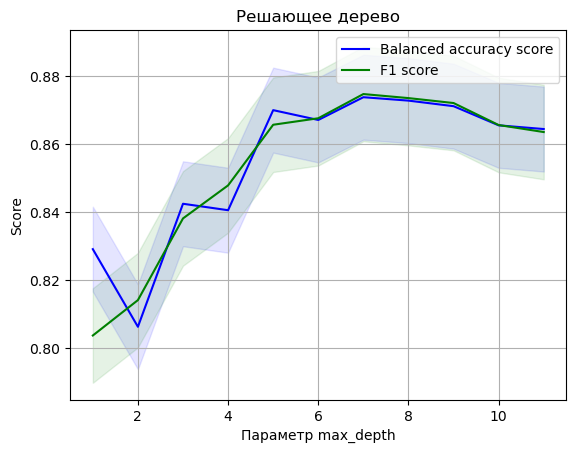

In [345]:
print(f"Лучший balanced_accuracy_score: {grid_search_dt_noPCA.best_score_}")

(X_plot, Y_plot) = create_plot_data(grid_search_dt_noPCA, x_col="param_max_depth")

fig, ax = plt.subplots()

CI = 1.96 * np.std(Y_plot[0])/np.sqrt(len(Y_plot[0]))
ax.plot(X_plot, Y_plot[0], label='Balanced accuracy score', color='b')
ax.fill_between(X_plot, (Y_plot[0]-CI), (Y_plot[0]+CI), color='b', alpha=.1)

CI = 1.96 * np.std(Y_plot[1])/np.sqrt(len(Y_plot[1]))
ax.plot(X_plot, Y_plot[1], label='F1 score', color='g')
ax.fill_between(X_plot, (Y_plot[1]-CI), (Y_plot[1]+CI), color='g', alpha=.1)

ax.set(xlabel='Параметр max_depth', ylabel='Score',
       title='Решающее дерево')
ax.grid()
ax.legend()

plt.show()

In [346]:
# Попробуем посмотреть прунинг на дереве с max_depth=None

dt_basic_pruned = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=None).fit(X_train, y_train)
path = dt_basic.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [347]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = clone(dt_basic)
    clf.set_params(ccp_alpha=ccp_alpha, max_depth=None, random_state=RANDOM_STATE)
    clf.fit(X_train, y_train)
    clfs.append(clf)

In [348]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

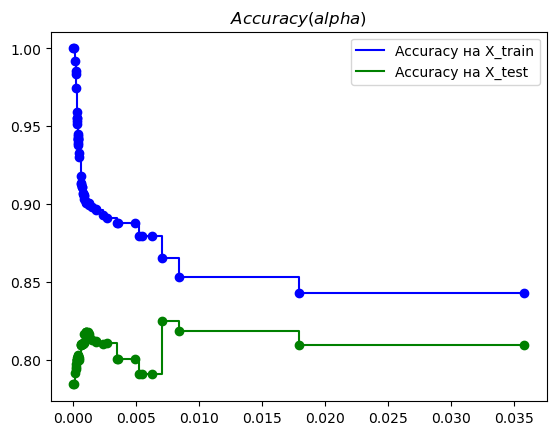

In [349]:
train_acc = []
test_acc = []
for c in clfs:
    y_train_pred = c.predict(X_train)
    y_test_pred = c.predict(X_test)
    train_acc.append(accuracy_score(c.predict(X_train),y_train))
    test_acc.append(accuracy_score(c.predict(X_test),y_test))

plt.scatter(ccp_alphas,train_acc, color='b')
plt.scatter(ccp_alphas,test_acc, color='g')
plt.plot(ccp_alphas,train_acc,label='Accuracy на X_train',drawstyle="steps-post", color='b')
plt.plot(ccp_alphas,test_acc,label='Accuracy на X_test',drawstyle="steps-post", color='g')
plt.legend()
plt.title('$Accuracy(alpha)$')
plt.show()

In [350]:
ccp_alpha_hand_picked = 0.006
dt_basic_pruned=clone(dt_basic)
dt_basic_pruned.set_params(ccp_alpha=ccp_alpha_hand_picked, max_depth=None, random_state=RANDOM_STATE)

dt_basic_pruned.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.006, random_state=42)

In [351]:
for estimator in {dt_basic, dt_basic_pruned}:
    if (estimator.get_params()['ccp_alpha'] == 0.0):
        print(f"Estimator: non-pruned {estimator.__class__.__name__}")
    else:
        print(f"Estimator: pruned {estimator.__class__.__name__}")
    num = 3
    print(f"Accuracy: \t{round(accuracy_score(y_val, estimator.predict(X_val)), num)}")
    print(f"Precision: \t{round(precision_score(y_val, estimator.predict(X_val)), num)}")
    print(f"Recall: \t{round(recall_score(y_val, estimator.predict(X_val)), num)}")
    print(f"f1 score: \t{round(f1_score(y_val, estimator.predict(X_val)), num)}")

Estimator: non-pruned DecisionTreeClassifier
Accuracy: 	0.797
Precision: 	0.594
Recall: 	0.813
f1 score: 	0.686
Estimator: pruned DecisionTreeClassifier
Accuracy: 	0.783
Precision: 	0.572
Recall: 	0.818
f1 score: 	0.673


Как мы видим, прунинг не сильно помог в улучшении оценки Решающего Дерева, т.к. мы вручную исключили параметр `max_depth=None` (оставили только целочисленные значения).

#### kNN классификатор

In [352]:
param_grid = {'n_neighbors' : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11] #без None
             }

estimator = KNeighborsClassifier()
grid_search_kNN_noPCA = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=cross_validation, verbose=1, refit='balanced_accuracy', scoring=grid_search_scoring)
grid_search_kNN_noPCA.fit(X_train, y_train)

Fitting 5 folds for each of 11 candidates, totalling 55 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]},
             refit='balanced_accuracy',
             scoring=['balanced_accuracy', 'precision', 'recall', 'f1_macro'],
             verbose=1)

In [353]:
kNN_basic = grid_search_kNN_noPCA.best_estimator_

Лучший balanced_accuracy_score: 0.8963112302342868


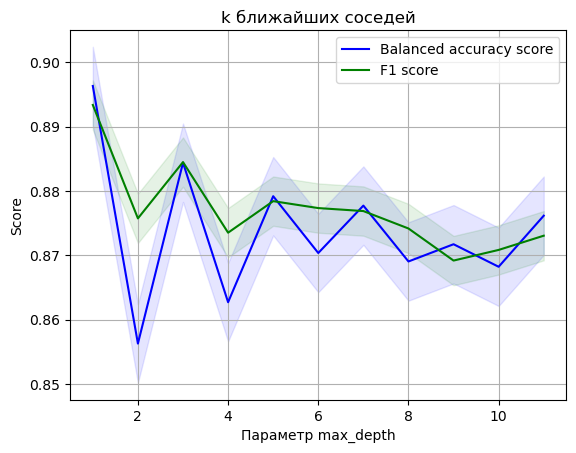

In [354]:
print(f"Лучший balanced_accuracy_score: {grid_search_kNN_noPCA.best_score_}")

(X_plot, Y_plot) = create_plot_data(grid_search_kNN_noPCA, x_col="param_n_neighbors")

fig, ax = plt.subplots()

CI = 1.96 * np.std(Y_plot[0])/np.sqrt(len(Y_plot[0]))
ax.plot(X_plot, Y_plot[0], label='Balanced accuracy score', color='b')
ax.fill_between(X_plot, (Y_plot[0]-CI), (Y_plot[0]+CI), color='b', alpha=.1)

CI = 1.96 * np.std(Y_plot[1])/np.sqrt(len(Y_plot[1]))
ax.plot(X_plot, Y_plot[1], label='F1 score', color='g')
ax.fill_between(X_plot, (Y_plot[1]-CI), (Y_plot[1]+CI), color='g', alpha=.1)

ax.set(xlabel='Параметр max_depth', ylabel='Score',
       title='k ближайших соседей')
ax.grid()
ax.legend()

plt.show()

#### Описание результатов

In [355]:
for estimator in {dt_basic, kNN_basic}:
    print(f"Estimator: {estimator.__class__.__name__}")

    num = 3
    print(f"Accuracy: \t{round(accuracy_score(y_val, estimator.predict(X_val)), num)}")
    print(f"Precision: \t{round(precision_score(y_val, estimator.predict(X_val)), num)}")
    print(f"Recall: \t{round(recall_score(y_val, estimator.predict(X_val)), num)}")
    print(f"f1 score: \t{round(f1_score(y_val, estimator.predict(X_val)), num)} \n")

Estimator: DecisionTreeClassifier
Accuracy: 	0.797
Precision: 	0.594
Recall: 	0.813
f1 score: 	0.686 

Estimator: KNeighborsClassifier
Accuracy: 	0.764
Precision: 	0.546
Recall: 	0.798
f1 score: 	0.649 



Сложно сравнить эти две модели, т.к. оба этих подхода по своему уникальны. `DecisionTree` это supervised-модель, когда как `kNN` - unsupervised-модель. 

`kNN` проигрывает, т.к. в нашей выборке большое количество признаков. Теперь применим PCA и попробуем снизить размерность:

### GridSearchCV после PCA

Обучим те же классификаторы на трансформированных с помощью PCA данных. Подберите оптимальные значения исследуемых гиперпараметров для новых данных. Постройте график среднего значения качества по кросс-валидации алгоритма при заданном значении гиперпараметра, на котором также отобразите доверительный интервал.

Что вы можете сказать о получившихся графиках? Какой алгоритм справился лучше? Какой быстрее? Почему?

#### PCA преобразование

Теперь попробуем сделать преобразрование данных с помощью PCA. Выберите оптимальное количество компонент и преобразуйте данные. Объясните свой выбор.

In [305]:
pca_full = PCA(n_components=X_train.shape[1], svd_solver='full', random_state=RANDOM_STATE)
pca_full.fit(X_train)

PCA(n_components=63, random_state=42, svd_solver='full')

Text(0, 0.5, 'Explained Variance (объясненное отклонение), ratio')

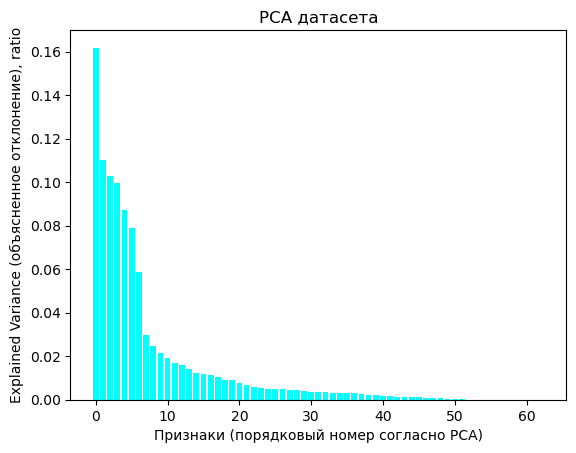

In [323]:
fig, ax = plt.subplots(1, 1)
res = pca_full.explained_variance_ratio_
ax.bar(list(range(0,len(res))), res, color='cyan')
ax.set_title("PCA датасета")
ax.set_xlabel("Признаки (порядковый номер согласно PCA)")
ax.set_ylabel("Explained Variance (объясненное отклонение), ratio")

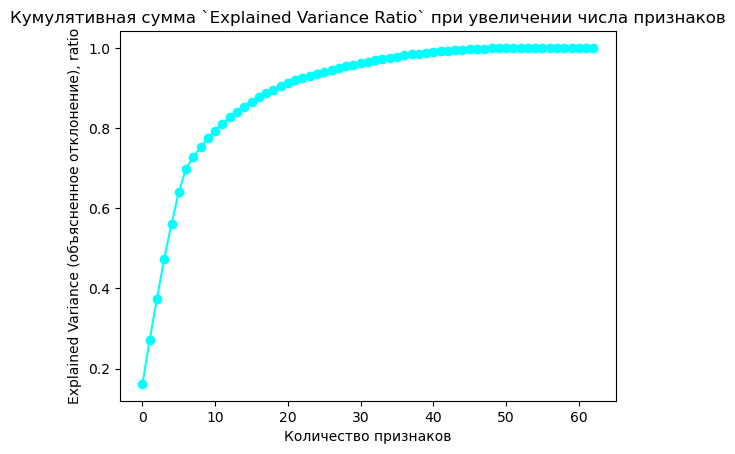

In [324]:
cumulative_variance_ratio = np.cumsum(res)
plt.plot(cumulative_variance_ratio, marker='o', color='cyan')
plt.xlabel('Количество признаков')
plt.ylabel('Explained Variance (объясненное отклонение), ratio')
plt.title('Кумулятивная сумма `Explained Variance Ratio` при увеличении числа признаков')
plt.show()

Согласно графикам выше, рекомендуется выбрать 40 признаков. Но мы выберем 10-20 и посмотрим на результаты кросс-валидации. Нас в первую очередь интересует производительность `kNN` без проклятия размерности

#### kNN и PCA

Анализ влияния "проклятия размерности" на эффективность `kNN`

In [311]:
pca_low = PCA(n_components=12, svd_solver='full', random_state=RANDOM_STATE) # Подобрал
X_train_pca_low = pca_low.fit_transform(X_train)
X_val_pca_low = pca_low.transform(X_val)

In [312]:
param_grid = {'n_neighbors' : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] #без None
             }

estimator = KNeighborsClassifier()
grid_search_kNN_wPCA_low = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=cross_validation, verbose=1, refit='balanced_accuracy', scoring=grid_search_scoring)
grid_search_kNN_wPCA_low.fit(X_train_pca_low, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             refit='balanced_accuracy',
             scoring=['balanced_accuracy', 'precision', 'recall', 'f1_macro'],
             verbose=1)

In [313]:
knn_pca_low = grid_search_kNN_wPCA_low.best_estimator_

In [314]:
pca_high = PCA(n_components=40, svd_solver='full', random_state=RANDOM_STATE) # Подобрал
X_train_pca_high = pca_high.fit_transform(X_train)
X_val_pca_high = pca_high.transform(X_val)

In [315]:
param_grid = {'n_neighbors' : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] #без None
             }

estimator = KNeighborsClassifier()
grid_search_kNN_wPCA_high = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=cross_validation, verbose=1, refit='balanced_accuracy', scoring=grid_search_scoring)
grid_search_kNN_wPCA_high.fit(X_train_pca_high, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             refit='balanced_accuracy',
             scoring=['balanced_accuracy', 'precision', 'recall', 'f1_macro'],
             verbose=1)

In [316]:
knn_pca_high = grid_search_kNN_wPCA_high.best_estimator_

In [319]:
num = 3
###
print(f"kNN, обученный на PC-трансформированном датасете с n=12:")
print(f"Accuracy: \t{round(accuracy_score(y_val, knn_pca_low.predict(X_val_pca_low)), num)}")
print(f"Precision: \t{round(precision_score(y_val, knn_pca_low.predict(X_val_pca_low)), num)}")
print(f"Recall: \t{round(recall_score(y_val, knn_pca_low.predict(X_val_pca_low)), num)}")
print(f"f1 score: \t{round(f1_score(y_val, knn_pca_low.predict(X_val_pca_low)), num)} \n")
###
print(f"kNN, обученный на PC-трансформированном датасете с n=40:")
print(f"Accuracy: \t{round(accuracy_score(y_val, knn_pca_high.predict(X_val_pca_high)), num)}")
print(f"Precision: \t{round(precision_score(y_val, knn_pca_high.predict(X_val_pca_high)), num)}")
print(f"Recall: \t{round(recall_score(y_val, knn_pca_high.predict(X_val_pca_high)), num)}")
print(f"f1 score: \t{round(f1_score(y_val, knn_pca_high.predict(X_val_pca_high)), num)} \n")

kNN, обученный на PC-трансформированном датасете с n=12:
Accuracy: 	0.781
Precision: 	0.573


Recall: 	0.779
f1 score: 	0.66 

kNN, обученный на PC-трансформированном датасете с n=40:
Accuracy: 	0.761
Precision: 	0.543
Recall: 	0.793
f1 score: 	0.645 



____
Можно видеть, как влияет количество признаков на производительность `kNN`. Попробуем исключить эффект "проклятия размерности" и применим PCA с `n_components`=12:

In [321]:
pca = PCA(n_components=12, svd_solver='full', random_state=RANDOM_STATE) # Подобрал
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

#### Решающее дерево



In [325]:
param_grid = {'max_depth' : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] #без None
             }

estimator = DecisionTreeClassifier(random_state=RANDOM_STATE)
grid_search_dt_withPCA = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=5, verbose=1, refit='balanced_accuracy', scoring=grid_search_scoring)
grid_search_dt_withPCA.fit(X_train_pca, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             refit='balanced_accuracy',
             scoring=['balanced_accuracy', 'precision', 'recall', 'f1_macro'],
             verbose=1)

In [326]:
dt_better = grid_search_dt_withPCA.best_estimator_

Лучший balanced_accuracy_score: 0.8497854168643599


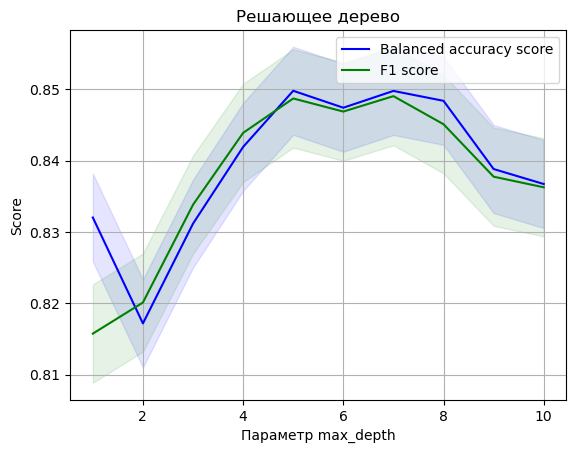

In [328]:
print(f"Лучший balanced_accuracy_score: {grid_search_dt_withPCA.best_score_}")

(X_plot, Y_plot) = create_plot_data(grid_search_dt_withPCA, x_col="param_max_depth")

fig, ax = plt.subplots()

CI = 1.96 * np.std(Y_plot[0])/np.sqrt(len(Y_plot[0]))
ax.plot(X_plot, Y_plot[0], label='Balanced accuracy score', color='b')
ax.fill_between(X_plot, (Y_plot[0]-CI), (Y_plot[0]+CI), color='b', alpha=.1)

CI = 1.96 * np.std(Y_plot[1])/np.sqrt(len(Y_plot[1]))
ax.plot(X_plot, Y_plot[1], label='F1 score', color='g')
ax.fill_between(X_plot, (Y_plot[1]-CI), (Y_plot[1]+CI), color='g', alpha=.1)

ax.set(xlabel='Параметр max_depth', ylabel='Score',
       title='Решающее дерево')
ax.grid()
ax.legend()

plt.show()

#### kNN классификатор

In [329]:
param_grid = {'n_neighbors' : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] #без None
             }

estimator = KNeighborsClassifier()
grid_search_kNN_withPCA = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=5, verbose=1, refit='balanced_accuracy', scoring=grid_search_scoring)
grid_search_kNN_withPCA.fit(X_train_pca, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             refit='balanced_accuracy',
             scoring=['balanced_accuracy', 'precision', 'recall', 'f1_macro'],
             verbose=1)

In [330]:
kNN_better = grid_search_kNN_withPCA.best_estimator_

Лучший balanced_accuracy_score: 0.8606896042411945


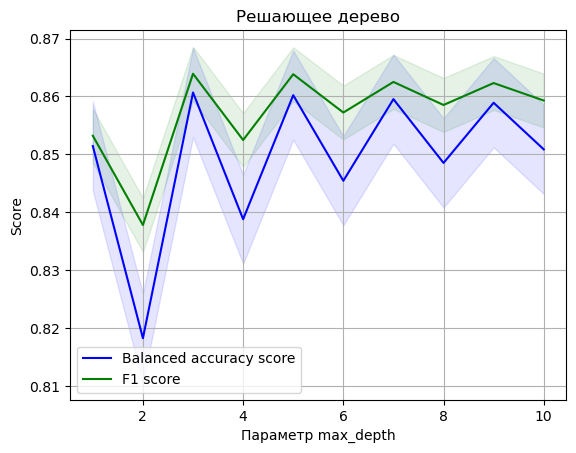

In [332]:
print(f"Лучший balanced_accuracy_score: {grid_search_kNN_withPCA.best_score_}")

(X_plot, Y_plot) = create_plot_data(grid_search_kNN_withPCA, x_col="param_n_neighbors")

fig, ax = plt.subplots()

CI = 1.96 * np.std(Y_plot[0])/np.sqrt(len(Y_plot[0]))
ax.plot(X_plot, Y_plot[0], label='Balanced accuracy score', color='b')
ax.fill_between(X_plot, (Y_plot[0]-CI), (Y_plot[0]+CI), color='b', alpha=.1)

CI = 1.96 * np.std(Y_plot[1])/np.sqrt(len(Y_plot[1]))
ax.plot(X_plot, Y_plot[1], label='F1 score', color='g')
ax.fill_between(X_plot, (Y_plot[1]-CI), (Y_plot[1]+CI), color='g', alpha=.1)

ax.set(xlabel='Параметр max_depth', ylabel='Score',
       title='Решающее дерево')
ax.grid()
ax.legend()

plt.show()

#### Описание результатов

In [333]:
for estimator in {dt_better, kNN_better}:
    print(f"Estimator: {estimator.__class__.__name__}")

    num = 3
    print(f"Accuracy: \t{round(accuracy_score(y_val, estimator.predict(X_val_pca)), num)}")
    print(f"Precision: \t{round(precision_score(y_val, estimator.predict(X_val_pca)), num)}")
    print(f"Recall: \t{round(recall_score(y_val, estimator.predict(X_val_pca)), num)}")
    print(f"f1 score: \t{round(f1_score(y_val, estimator.predict(X_val_pca)), num)} \n")

Estimator: KNeighborsClassifier
Accuracy: 	0.781


Precision: 	0.573
Recall: 	0.779
f1 score: 	0.66 

Estimator: DecisionTreeClassifier
Accuracy: 	0.794
Precision: 	0.592
Recall: 	0.782
f1 score: 	0.674 



`DecisionTree` все равно показал себя лучше `kNN`, однако уменьшение размерности позволило `kNN` приблизиться намного ближе к дереву по нескольким метрикам. Возьмем например `f1-метрику`:

| PCA? | kNN | DT |
| --- | --- | --- |
| - | 0.649 | 0.686 |
| + | 0.660 | 0.674 |

## Сравнение результатов

Сравните результаты полученные до трансформации данных с помощью PCA и после. Есть ли изменения динамики среднего значения качества по кросс-валидации алгоритма? Объясните почему?

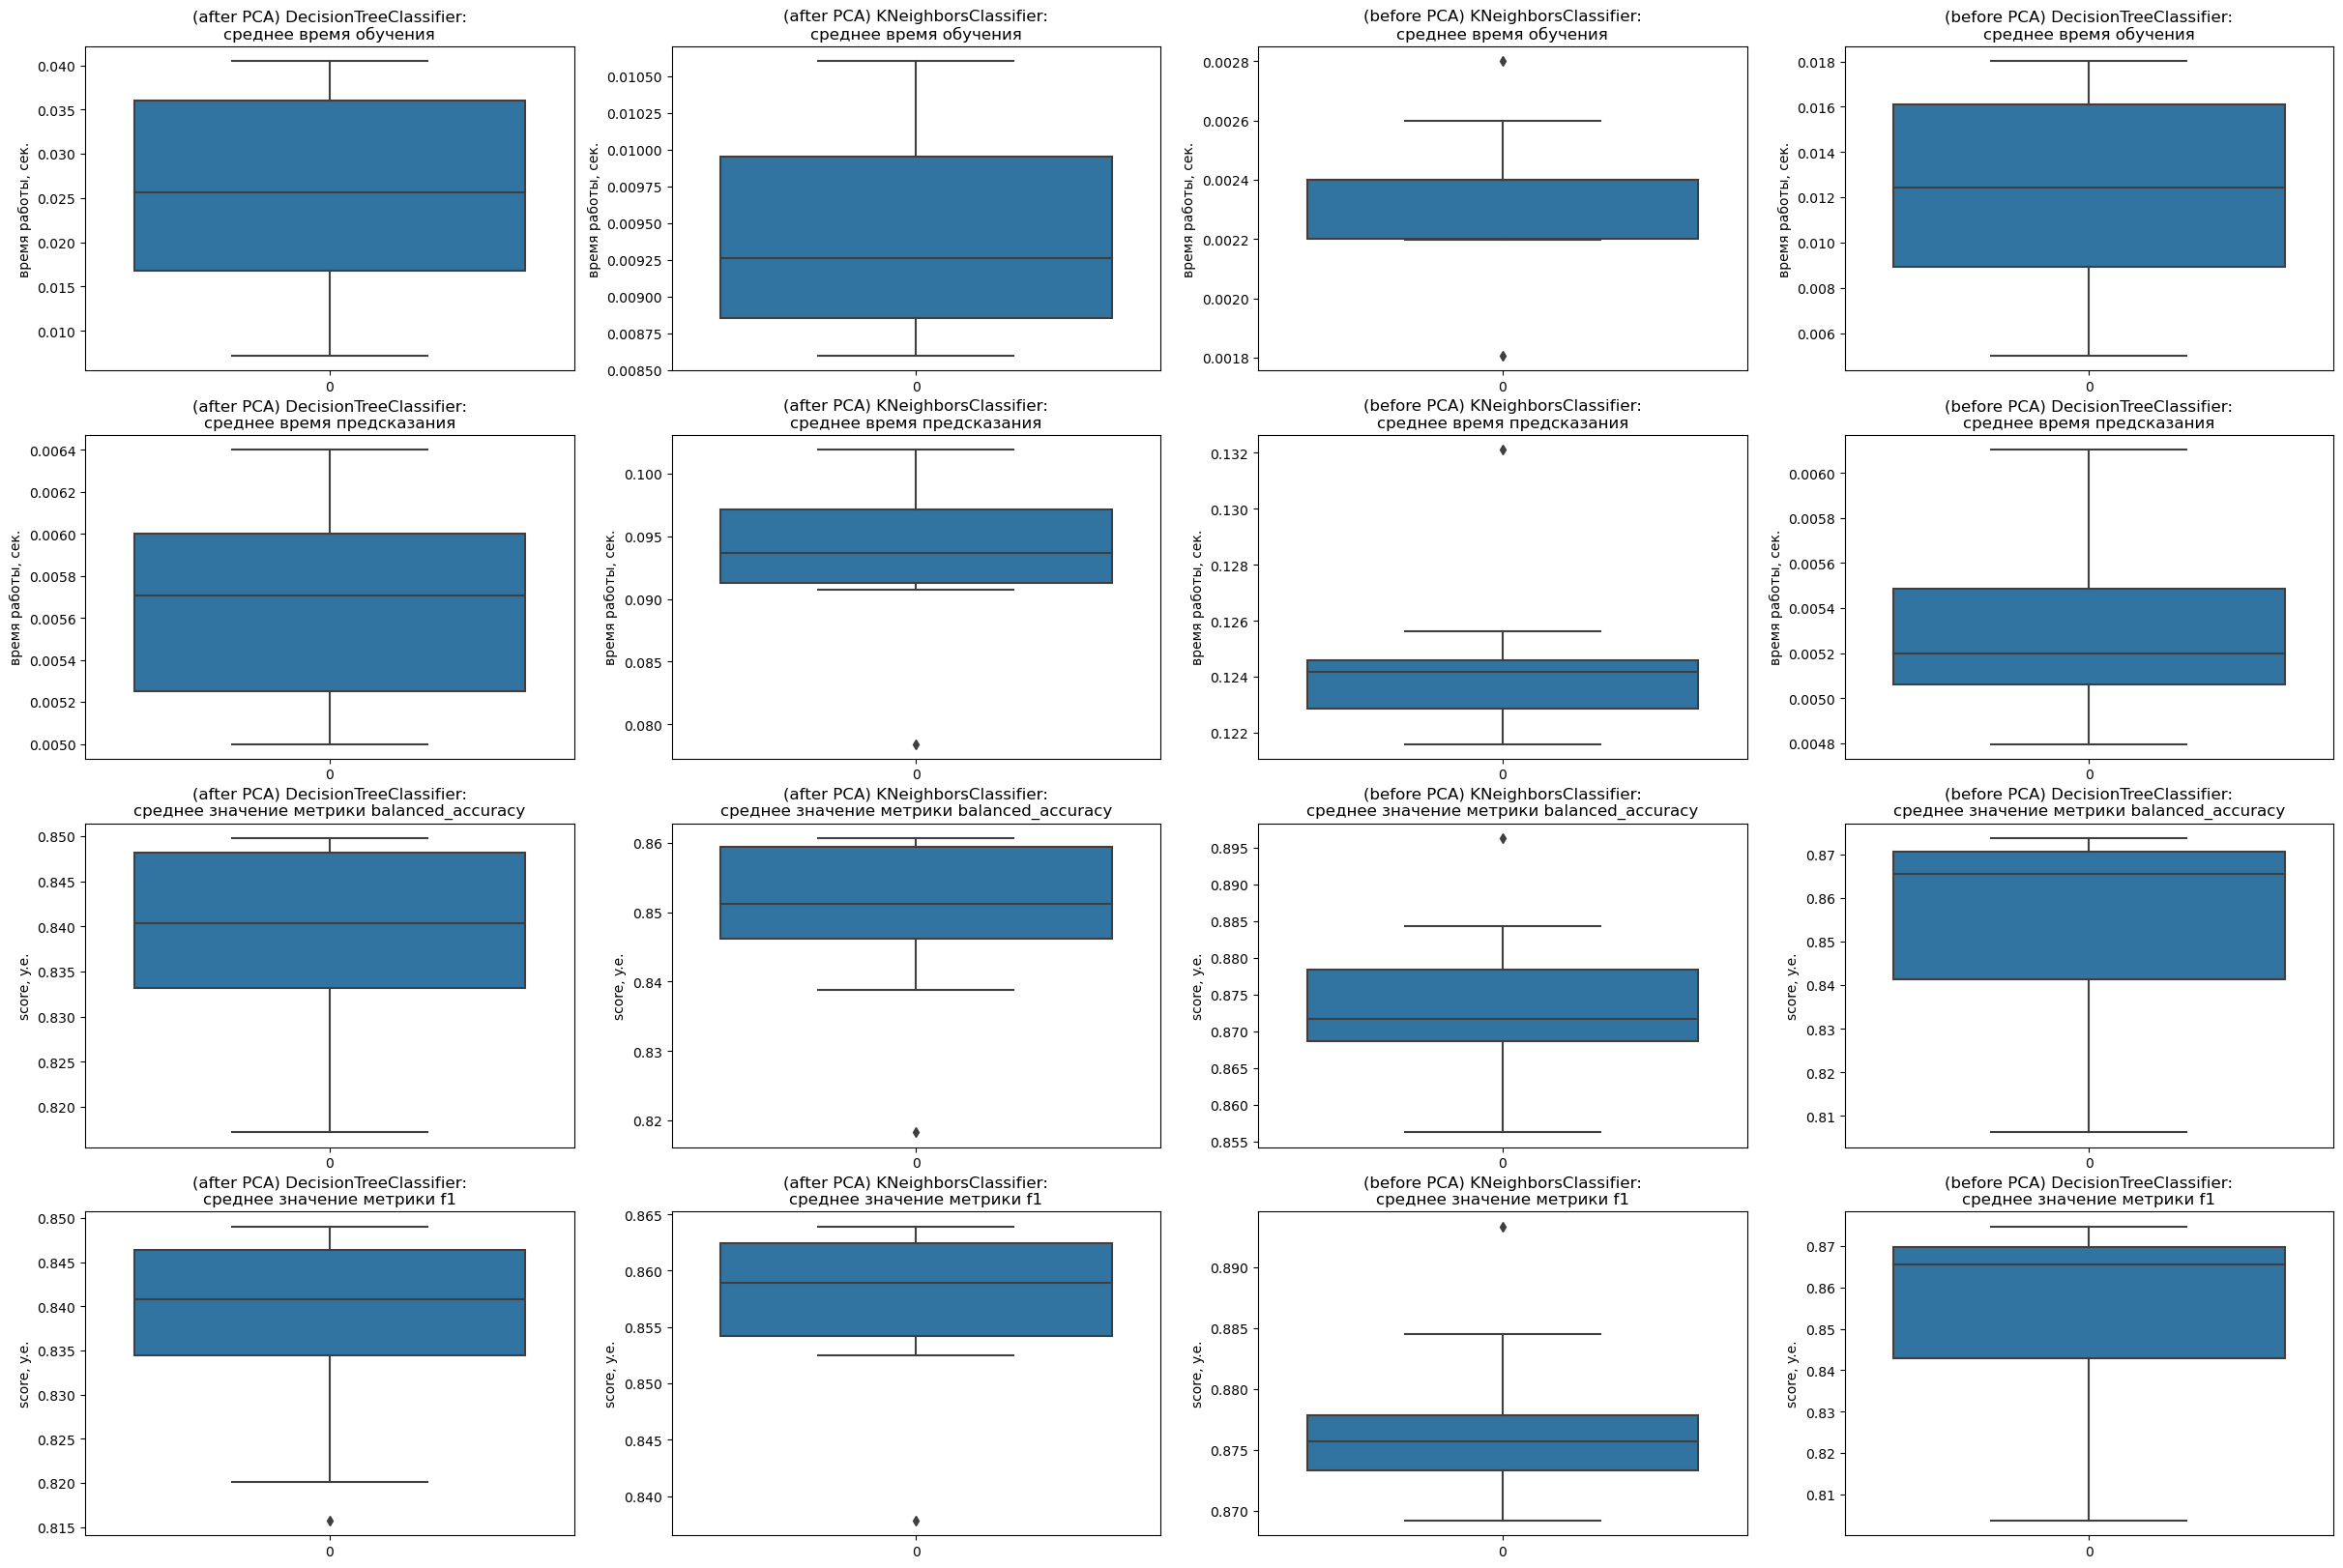

In [361]:
# GSCV = GridSearchCV, поиск параметров по сетке и кросс-валидация
fig, ax = plt.subplots(4, 4)
fig.set_figheight(20)
fig.set_figwidth(30)
i = 0

for GSCV in {grid_search_dt_noPCA, grid_search_dt_withPCA, grid_search_kNN_noPCA, grid_search_kNN_withPCA}:
    mft = GSCV.cv_results_["mean_fit_time"]
    mst = GSCV.cv_results_["mean_score_time"]
    mt_acc = GSCV.cv_results_["mean_test_balanced_accuracy"]
    mt_f1 = GSCV.cv_results_["mean_test_f1_macro"]

    if (len(GSCV.cv_results_['mean_fit_time']) > 10):
        title = "(before PCA) "
    else:
        title = "(after PCA) "

    sns.boxplot(data=mft, ax=ax[0, i])
    ax[0, i].set_title(title+f"{str(GSCV.best_estimator_.__class__.__name__)}:\nсреднее время обучения")
    ax[0, i].set_ylabel("время работы, сек.")

    sns.boxplot(data=mst, ax=ax[1, i])
    ax[1, i].set_title(title+f"{str(GSCV.best_estimator_.__class__.__name__)}:\nсреднее время предсказания")
    ax[1, i].set_ylabel("время работы, сек.")

    sns.boxplot(data=mt_acc, ax=ax[2, i])
    ax[2, i].set_title(title+f"{str(GSCV.best_estimator_.__class__.__name__)}:\nсреднее значение метрики balanced_accuracy")
    ax[2, i].set_ylabel("score, y.e.")

    sns.boxplot(data=mt_f1, ax=ax[3, i])
    ax[3, i].set_title(title+f"{str(GSCV.best_estimator_.__class__.__name__)}:\nсреднее значение метрики f1")
    ax[3, i].set_ylabel("score, y.e.")

    i+=1

В итоге получаем на кросс валидации следующие результаты: `kNN`, который хотя и намного проще `DecisionTreeClassifier`, обучался гораздо дольше до PCA и одинаково быстро после PCA. По метрике `f1` после PCA стал эффективнее дерева на кросс-валидации. Но стоит заметить, что мы не смотрели эффективность моделей на валидационной выборке.

Рассмотрим подробно какие гиперпараметры попали в интервал $$value \in (-\infty; Q_1-1.5\times IQR)$$

где:
* $IQR = Q_3 - Q_1$ - Межквартильный размах;
* $Q_1$ - первый квартиль;
* $Q_3$ - третий квартиль.

In [362]:
for i, GSCV in enumerate({grid_search_dt_noPCA, grid_search_dt_withPCA, grid_search_kNN_noPCA, grid_search_kNN_withPCA}):
    mt_f1 = GSCV.cv_results_["mean_test_f1_macro"]

    q1 = np.quantile(mt_f1, 0.25)
    q3 = np.quantile(mt_f1, 0.75)
    iqr = q3-q1
    lower_b = q1-(1.5*iqr)
    upper_b = q3+(1.5*iqr)
    values = list(mt_f1)

    # Считаем выбросы
    outlier_arr = []
    if (len(GSCV.cv_results_['mean_fit_time']) > 10):
        print(f"Параметры моделей 'before PCA' {str(GSCV.best_estimator_.__class__.__name__)}, для которых значение метрики меньше Q_1:")
    else:
        print(f"Параметры моделей 'after PCA' {str(GSCV.best_estimator_.__class__.__name__)}, для которых значение метрики меньше Q_1:")

    for elem in values:
        if elem < lower_b:
            outlier_arr.append(values.index(elem))

    for idx in outlier_arr:
        print(GSCV.cv_results_['params'][idx])

    print("\n")
    

Параметры моделей 'after PCA' DecisionTreeClassifier, для которых значение метрики меньше Q_1:
{'max_depth': 1}


Параметры моделей 'after PCA' KNeighborsClassifier, для которых значение метрики меньше Q_1:
{'n_neighbors': 2}


Параметры моделей 'before PCA' KNeighborsClassifier, для которых значение метрики меньше Q_1:


Параметры моделей 'before PCA' DecisionTreeClassifier, для которых значение метрики меньше Q_1:




Закономерный вывод: максимальная глубина дерева сильно влияет на качество предсказания модели, ровно как и количество соседей у `kNN`. 

С другой стороны, большая глубина может перейти в `max_depth: None`, когда дерево гарантированно переобучается и необходим прунинг. А у `kNN` увеличится вычислительная сложность предсказания при увеличении параметра `n_neighbors`, но не приведет явно к переобучению. 

## Тестирование всех модели

Протестируйте все построенные модели (в т.ч. с и без PCA трансформации) на данных, которые были отложены для теста (их должно было остаться 40%). Не забудьте про все необходимые преобразования.

In [365]:
pairs = {(grid_search_dt_noPCA.best_estimator_, grid_search_dt_withPCA.best_estimator_), 
         (grid_search_kNN_noPCA.best_estimator_, grid_search_kNN_withPCA.best_estimator_)}

for estimators in pairs:
    print(f"####### Итоги для {estimators[0].__class__.__name__}")
    print(f"до PCA-трансформации")
    y_pred_basic = estimators[0].predict(X_test)
    acc_basic = balanced_accuracy_score(y_test, y_pred_basic)
    print(f"\tМетрика balanced_accuracy: {acc_basic:.4f}")
    f1_basic = f1_score(y_test, y_pred_basic)
    print(f"\tМетрика f1_score: {f1_basic:.4f}")

    print(f"после PCA-трансформации")
    y_pred_better = estimators[1].predict(X_test_pca)
    acc_basic = balanced_accuracy_score(y_test, y_pred_better)
    print(f"\tМетрика balanced_accuracy: {acc_basic:.4f}")
    f1_basic = f1_score(y_test, y_pred_better)
    print(f"\tМетрика f1_score: {f1_basic:.4f}")

    print('\n')


####### Итоги для DecisionTreeClassifier
до PCA-трансформации
	Метрика balanced_accuracy: 0.8101
	Метрика f1_score: 0.6723
после PCA-трансформации
	Метрика balanced_accuracy: 0.7984
	Метрика f1_score: 0.6633


####### Итоги для KNeighborsClassifier
до PCA-трансформации
	Метрика balanced_accuracy: 0.7819
	Метрика f1_score: 0.6313
после PCA-трансформации


	Метрика balanced_accuracy: 0.7875
	Метрика f1_score: 0.6472




#### Лучшее Решающее дерево

              precision    recall  f1-score   support

           0       0.93      0.80      0.86      4630
           1       0.57      0.82      0.67      1504

    accuracy                           0.80      6134
   macro avg       0.75      0.81      0.77      6134
weighted avg       0.84      0.80      0.81      6134

Train score 0.8665676077265972
Val score 0.6864501679731242
Test score 0.6722734671730873
Матрица конфузии на Train выборке


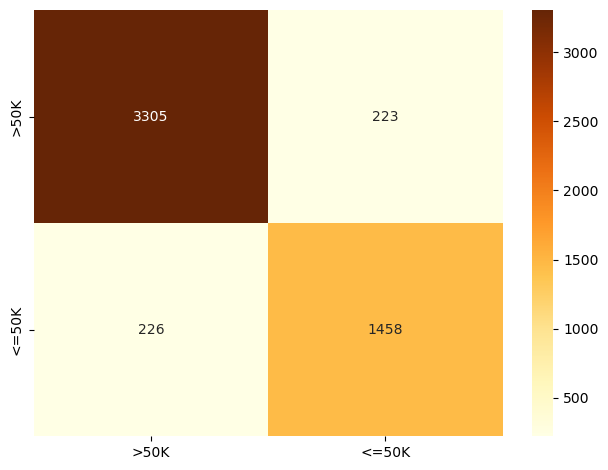

Матрица конфузии на Test выборке


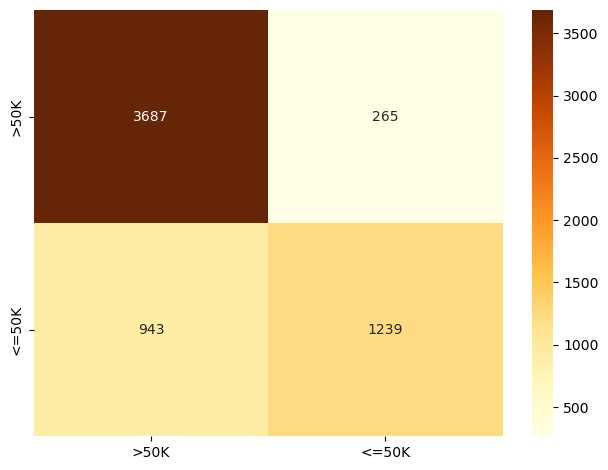

<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

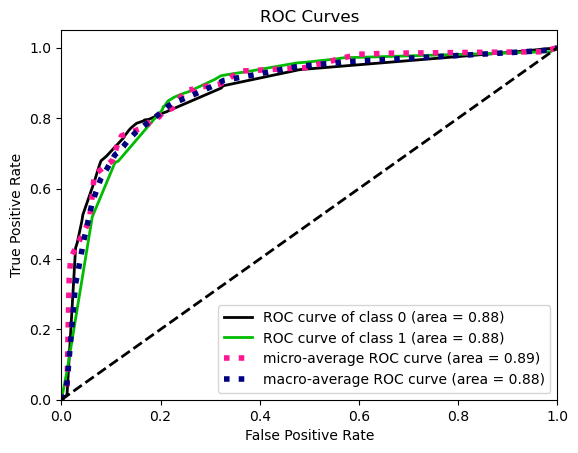

In [366]:
final_model = grid_search_dt_noPCA.best_estimator_

print(skl.metrics.classification_report(y_test, final_model.predict(X_test)))

print(f'Train score {f1_score(final_model.predict(X_train),y_train)}')
print(f'Val score {f1_score(final_model.predict(X_val),y_val)}')
print(f'Test score {f1_score(final_model.predict(X_test),y_test)}')

plot_confusionmatrix(final_model.predict(X_train),y_train,dom='Train')
plot_confusionmatrix(final_model.predict(X_test),y_test,dom='Test')

skplt.metrics.plot_roc(y_test, final_model.predict_proba(X_test))

#### Лучший kNN

              precision    recall  f1-score   support

           0       0.92      0.80      0.85      4630
           1       0.55      0.78      0.65      1504

    accuracy                           0.79      6134
   macro avg       0.74      0.79      0.75      6134
weighted avg       0.83      0.79      0.80      6134

Train score 0.8981818181818182
Val score 0.659921304103429
Test score 0.6471562672556598
Матрица конфузии на Train выборке


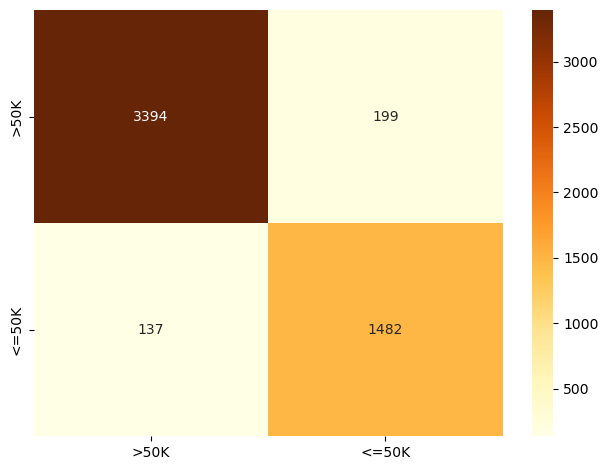

Матрица конфузии на Test выборке


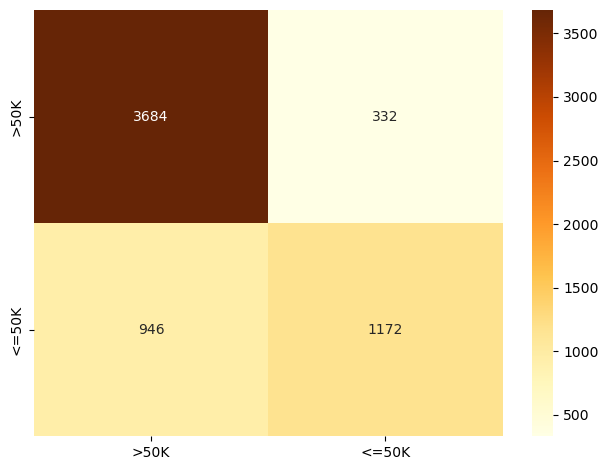

<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

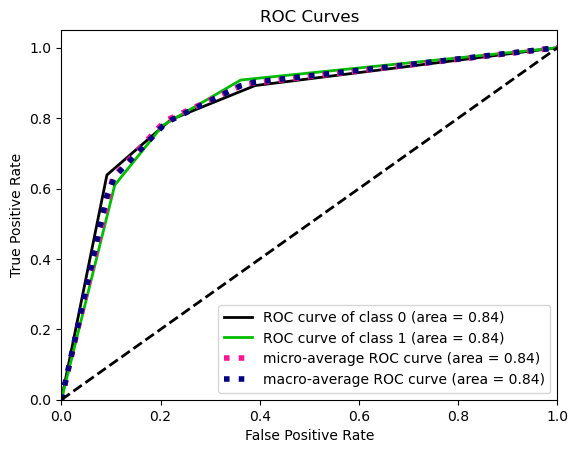

In [368]:
final_model = grid_search_kNN_withPCA.best_estimator_

print(skl.metrics.classification_report(y_test, final_model.predict(X_test_pca)))

print(f'Train score {f1_score(final_model.predict(X_train_pca),y_train)}')
print(f'Val score {f1_score(final_model.predict(X_val_pca),y_val)}')
print(f'Test score {f1_score(final_model.predict(X_test_pca),y_test)}')

plot_confusionmatrix(final_model.predict(X_train_pca),y_train,dom='Train')
plot_confusionmatrix(final_model.predict(X_test_pca),y_test,dom='Test')

skplt.metrics.plot_roc(y_test, final_model.predict_proba(X_test_pca))

# Вывод



Получились интересные результаты. Важный шаг, который был проведен до обучения классификаторов - балансирование датасета. Без нее не была бы достигнуты возможности предсказания `DecisionTree` (`kNN` бы это пережил). Согласно [распределению объектов](#pairplot_before), только малая часть минорного класса находится по одну сторону в пространстве признаков.

Далее, `DecisionTree` и `kNN` были обучены до PCA-трансформации и после. PCA показал эффект "проклятия размерности" на `kNN` (этот классификатор был использован, как самый чувствительный к размерности датасета), из-за чего количество компонент one-hot-закодированной выборки снизилось с 63 до 13.

Результаты кросс-валидации показали, что до и после PCA точность `kNN` повысилась, а у `DecisionTree` повысилась (причем на одинаковое значение по модулю - интересный факт). Однако тестирование на валидационной и тестовой выборках, а также анализ лучших классификаторов каждого типа привели к тому, что оба этих классификатора одинаково эффективны, соласно метрикам `f1` и `balanced-accuracy`.

Из этого можно заключить вывод, что этих двух моделей совершенно разного подхода на фундаментальном уровне (supervised/unsupervised learning) нельзя выбрать лучшую. Однако в контексте этой задачи выигрывает `DecisionTree`, т.к. дерево, в отличии от `kNN`, эффективнее работает на большом датасете с высокими размерностями. Вычислительная сложность дерева увеличивается от размерности `dim` (обычно) как $O(\sqrt{dim})$ или $O(log(dim))$, когда как `kNN` $O(dim)$. Также, дерево эффективнее по памяти и по времени предсказания, если сравнивать на больших датасетах.